### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import geoplot.crs as gcrs
import geoplot as gplt
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

### Loading data

In [2]:
import pandas as pd
df_l = pd.read_csv('data/listings.csv', low_memory=False)
df_geo = gpd.read_file('data/neighbourhoods.geojson')

In [3]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['#1e88e5', '#eeeeee', '#ff0d57'])
cmap_r = LinearSegmentedColormap.from_list('mycmap_r', ['#ff0d57', '#eeeeee', '#1e88e5'])
pinks = LinearSegmentedColormap.from_list('mycmap_pinks', ['#ffffff', '#ff0d57'])
azures = LinearSegmentedColormap.from_list('mycmap_pinks', ['#ffffff', '#1e88e5'])

In [4]:
df_l.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,gmaps_result,centre_transit_time
0,23163,https://www.airbnb.com/rooms/23163,20200229181007,2020-03-01,"Quiet 1BR directly in the Centre, Air-conditio...","Unique and elegant apartment rental in Prague,...",Unique and elegant apartment rental in Prague ...,"Unique and elegant apartment rental in Prague,...",none,Check my guidebook for this apartment to disco...,"To help you with your first steps in Prague, I...",The closest METRO station is called „Narodni t...,NaN,"Of course, you can contact me anytime during y...",Thank you for treating the property like it wa...,NaN,NaN,https://a0.muscache.com/im/pictures/01bbe32c-3...,NaN,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Prague, Czech Republic","Hello, \r\nglad to see that you are interested...",within an hour,97%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,69.0,69.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Prague, Czech Republic, Czech Republic",Staré Město,Praha 1,NaN,Prague,Czech Republic,11000,Prague,"Prague, Czech Republic",CZ,Czech Republic,50.08229,14.41552,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",775.0,"$3,717.00",NaN,NaN,"$2,546.00",NaN,2,$636.00,1,365,1,7,365,365,5.6,365.0,today,t,19,40,70,288,2020-03-01,19,3,2010-09-20,2019-07-27,98.0,9.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,moderate,f,f,69,68,0,0,0.17,{'destination_addresses': ['Staroměstské nám. ...,9.883333


In [5]:
counts = df_l.groupby('neighbourhood_cleansed', as_index = False)['id'].count()

In [6]:
counts['ratio'] = counts['id'] /  df_l.shape[0]

In [7]:
counts.columns = ['neighbourhood', 'count', 'ratio']

In [8]:
df_geo = df_geo.merge(counts, on = 'neighbourhood', how= 'left')

In [9]:
df_geo['coords'] = df_geo['geometry'].apply(lambda x: x.centroid)

In [10]:
points_df = df_geo[['neighbourhood', 'coords']]

In [11]:
points_df.columns = ['name', 'geometry']
df_p = gpd.GeoDataFrame(points_df)

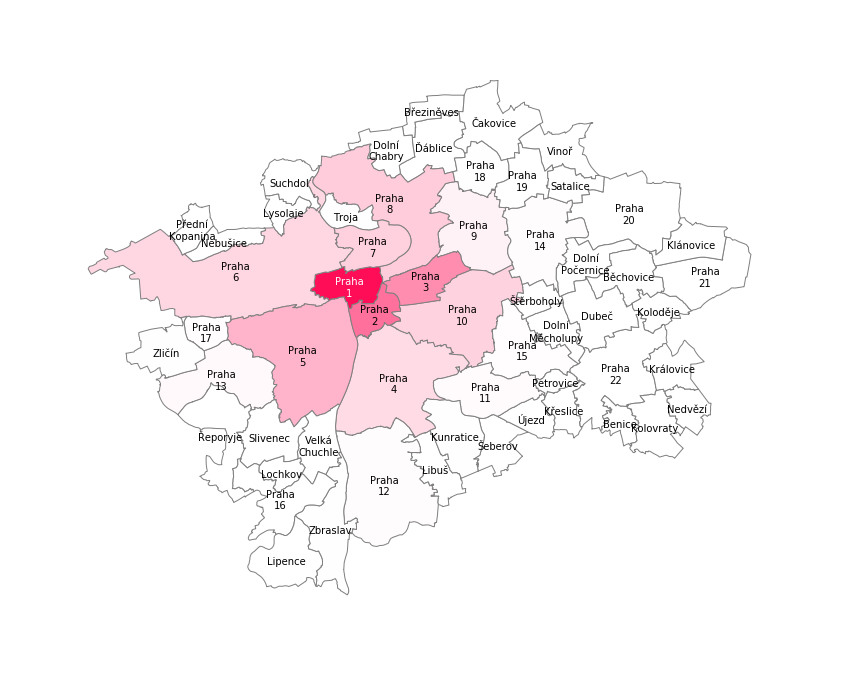

In [12]:
df_geo_nn = df_geo[df_geo['ratio'].notnull()]
ax = gplt.choropleth(df_geo, 
                     projection=gcrs.EuroPP(),
                     hue = df_geo['ratio'],
                     cmap = pinks,
                     edgecolor='grey', linewidth=1,
                     figsize=(15, 15))
for i, item in df_geo.to_crs('EPSG:25832').centroid.iteritems():
        ax.annotate(s=df_geo.iloc[i]['neighbourhood'].replace(' ', '\n'), 
            xy=[item.x, item.y], 
            color= 'black' if not (df_geo.iloc[i]['neighbourhood'] == 'Praha 1') else 'white', 
            horizontalalignment='center',
            verticalalignment='center')

In [13]:
points = gpd.GeoDataFrame(
    df_l, geometry=gpd.points_from_xy(df_l.longitude, df_l.latitude))

/opt/conda/lib/python3.7/site-packages/geoplot/geoplot.py:625: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  extent = gpd.GeoSeries(self.extent) if self.extent is not None else None


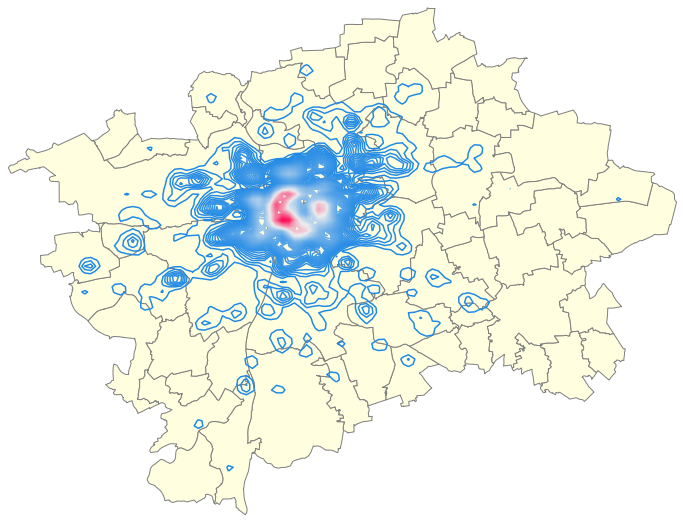

In [14]:
ax = gplt.polyplot(df_geo, 
                     projection=gcrs.AlbersEqualArea(),
                     edgecolor='grey', facecolor='lightyellow', linewidth=1, figsize=(12, 12))

gplt.kdeplot(points, n_levels=200, cmap = cmap, projection=gcrs.AlbersEqualArea(), extent = df_geo.total_bounds, ax = ax)
plt.show()

In [15]:
df_time_grouped = df_l.groupby('neighbourhood_cleansed')['centre_transit_time'].mean().reset_index()
df_time_grouped.columns = ['neighbourhood', 'centre_transit_time']

In [16]:
df_geo = df_geo.merge(df_time_grouped, on="neighbourhood", how = 'left')

/opt/conda/lib/python3.7/site-packages/geoplot/geoplot.py:625: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  extent = gpd.GeoSeries(self.extent) if self.extent is not None else None


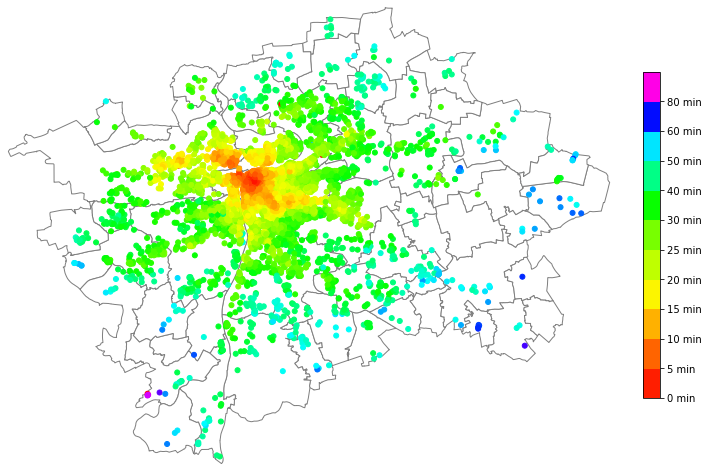

In [17]:
ax = gplt.polyplot(df_geo, 
                     projection=gcrs.AlbersEqualArea(),
                     edgecolor='grey', facecolor='white', linewidth=1, figsize=(12, 12))
gplt.pointplot(points, hue='centre_transit_time', 
               projection=gcrs.AlbersEqualArea(), 
               extent = df_geo.total_bounds, 
               cmap='hsv',
               legend = True,
               legend_kwargs= {'shrink': 0.5, 
                               'fraction': 0.05, 
                               'pad': 0.05,
                               'format': '%.0f min',
                               'ticks': [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80],
                               'boundaries': [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100]
                              },
               ax = ax)
plt.show()

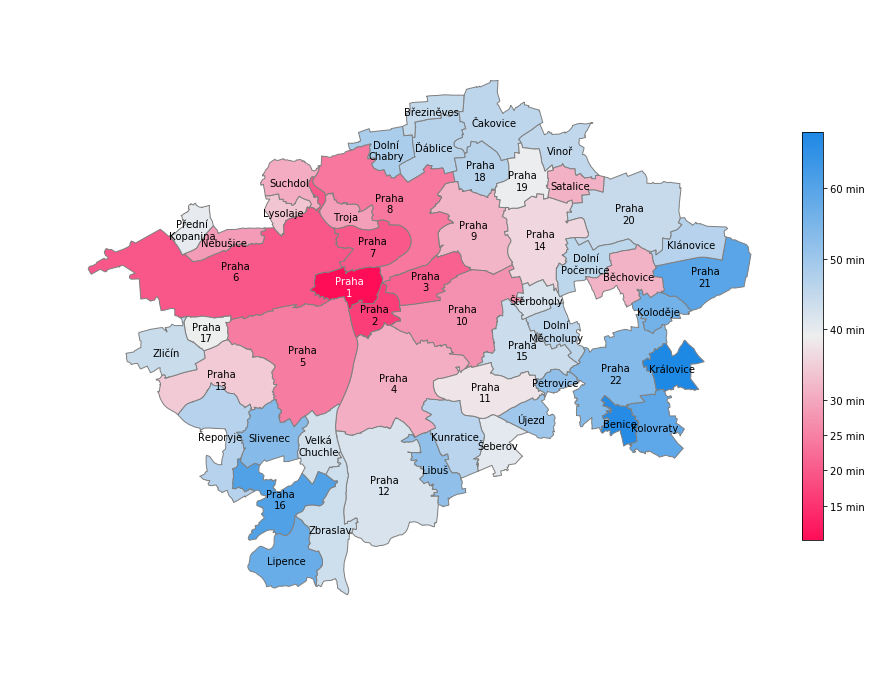

In [18]:
df_geo_nn = df_geo[df_geo['centre_transit_time'].notnull()]
ax = gplt.choropleth(df_geo_nn, 
                     projection=gcrs.EuroPP(),
                     hue = df_geo_nn['centre_transit_time'],
                     cmap = cmap_r,
                     edgecolor='grey', 
                     linewidth=1,
                     legend = True,
                     legend_kwargs= {'shrink': 0.5, 
                                     'fraction': 0.05, 
                                     'pad': -0.05,
                                     'format': '%.0f min',
                                     'ticks': [0, 1, 10, 15, 20, 25, 30, 40, 50, 60]},
                     figsize=(15, 15))
for i, item in df_geo.to_crs('EPSG:25832').centroid.iteritems():
    if not (np.isnan(df_geo.iloc[i]['centre_transit_time'])):
        ax.annotate(s=df_geo.iloc[i]['neighbourhood'].replace(' ', '\n'), 
                    xy=[item.x, item.y], 
                    color= 'black' if not (df_geo.iloc[i]['neighbourhood'] == 'Praha 1') else 'white',
                    horizontalalignment='center',
                    verticalalignment='center')